# Trajectory vs. Grid Models

[Contrails API](https://api.contrails.org) supports model evaluation over a flight trajectory and model evaluation over a temporal-spatial grid.

Given a single flight trajectory, our API can be used to predict its contrail impact via two different approaches.

- Post the flight to the `/trajectory/cocip` to get per-waypoint predictions.
- Request `/grid/cocip` data, then interpolate the flight against the gridded predictions to arrive at per-waypoint predictions.

This notebook demonstrates and discusses both approaches. 

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import xarray as xr

In [2]:
# Define credentials
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]  # put in your API key here
HEADERS = {"x-api-key": API_KEY}

## Create synthetic flight

Assume a constant cruising speed of 230 m/s along a north-pointing geodesic

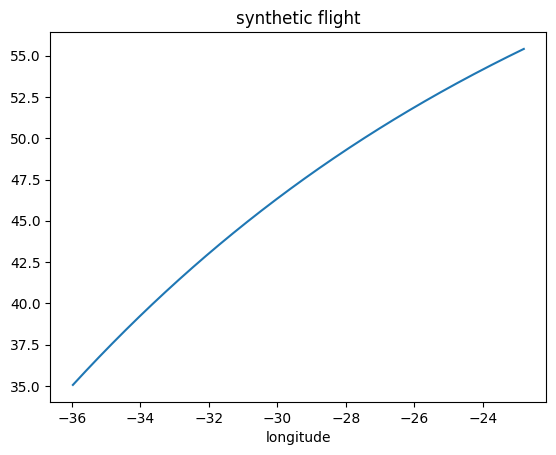

In [3]:
geod = pyproj.Geod(ellps="WGS84")
lon1 = -36
lat1 = 35
az = 20
n_waypoints = 360  # waypoint every 30 seconds
dist = 230 * 30  # 230 m/s
out = geod.fwd_intermediate(lon1, lat1, az, n_waypoints, dist, return_back_azimuth=False)

t0 = "2022-06-07T03:00:00"
t1 = "2022-06-07T06:00:00"

fl = pd.DataFrame()
fl["longitude"] = out.lons
fl["latitude"] = out.lats
fl["altitude"] = np.linspace(40000, 35000, n_waypoints)
fl["time"] = pd.date_range(t0, t1, periods=n_waypoints)

fl.plot("longitude", "latitude", legend=False, title="synthetic flight");

## Trajectory approach

Post this flight to the `/trajectory/cocip` endpoint.

In [4]:
# Convert from datetime to int timestamp
payload = fl.assign(time=fl["time"].astype(int)).to_dict("list")
payload["aircraft_type"] = "A320"

r = requests.post(f"{URL}/v0/trajectory/cocip", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json = r.json()
ef_traj = r_json["energy_forcing"]

HTTP Response Code: 200 OK


## Grid approach

Request gridded CoCiP data. Our query parameters define a temporal-spatial bounding box covering the flight.

In [5]:
params = {
    # Give the bbox a small buffer
    "bbox": [
        fl["longitude"].min() - 1,
        fl["latitude"].min() - 1,
        fl["longitude"].max() + 1,
        fl["latitude"].max() + 1,
    ],
    "aircraft_type": "A320",
}

# Make four requests - each is quick.
ds_list = []
times = pd.date_range(t0, t1, freq="1h")
for t in times:
    params["time"] = str(t)
    r = requests.get(f"{URL}/v0/grid/cocip", params=params, headers=HEADERS)
    print(f"HTTP Response Code: {r.status_code} {r.reason}")

    # Save request to disk, open with xarray, append grid to ds_list
    with tempfile.NamedTemporaryFile() as tmp, open(tmp.name, "wb") as file_obj:
        file_obj.write(r.content)
        ds = xr.load_dataset(tmp.name, engine="netcdf4", decode_timedelta=False)
    ds_list.append(ds)

# Concatenate all grids into a single xr.Dataset
ds = xr.concat(ds_list, dim="time")

HTTP Response Code: 200 OK


HTTP Response Code: 200 OK


HTTP Response Code: 200 OK


HTTP Response Code: 200 OK


### Interpolate the trajectory to the grid

Several ways to interpolate 1-D trajectory data against a 4-D grid.

- [Interpolation with xarray](https://docs.xarray.dev/en/stable/user-guide/interpolation.html#advanced-interpolation). Used in this notebook for convenience.
- [Interpolation with scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html). This is often more performant, and is used under the hood by `xarray`, but it requires some additional work (for example, converting datetime to float).

In [6]:
# Extract 4-D grid of interest
da = ds["ef_per_m"]

# Convert pd.DataFrame to xr.Dataset
fl_ds = fl.copy()
fl_ds["flight_level"] = fl_ds.pop("altitude") / 100
# here, interp_dim is the common dimension mentioned in the xarray documentation
fl_ds = fl_ds.rename_axis("interp_dim")
fl_ds = xr.Dataset.from_dataframe(fl_ds)

# Run the interpolation
ef_per_m = da.interp(**fl_ds.data_vars, kwargs=dict(bounds_error=True))

# Convert from ef per meter to ef per waypoint
ef_grid = ef_per_m * dist

## Comparison

Plot the time series for each prediction method. The two approaches show broad agreement.

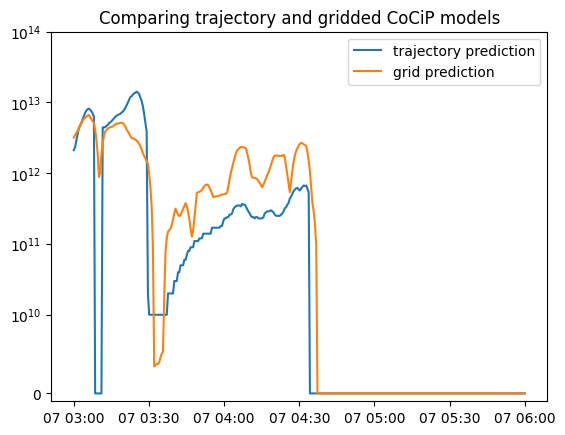

In [7]:
from matplotlib.scale import SymmetricalLogScale

fig, ax = plt.subplots()
ax.plot(fl["time"], ef_traj, label="trajectory prediction")
ax.plot(fl["time"], ef_grid, label="grid prediction")

ax.set_yscale(SymmetricalLogScale(None, linthresh=1e10))
ax.set_ylim(-1e9, 1e14)
ax.legend()
ax.set_title("Comparing trajectory and gridded CoCiP models");

In [8]:
print(f"EF predicted by the /trajectory endpoint: {sum(ef_traj) // 1e12} TJ (terajoules)")
print(f"EF predicted by the /grid endpoint:       {ef_grid.sum().item() // 1e12} TJ (terajoules)")

EF predicted by the /trajectory endpoint: 422.0 TJ (terajoules)
EF predicted by the /grid endpoint:       358.0 TJ (terajoules)


## Discussion

The differences highlighted in this notebook are typical: While both approaches predict the same order of magnitude for total energy forcing, we often see substantial differences between the outputs. These differences can be drastic, as exemplified by the vanishing of the trajectory energy forcing predictions for several minutes starting at 2022-06-07 03:08:00 (the dip in the blue curve). This difference is a consequence of the sensitivity of the CoCiP initial contrail persistence model at the specific conditions around this time. In other words, the predictions for each approach may diverge in situations at which CoCiP is sensitive to ambient conditions.

### Why do the two approaches give different predictions?

#### Aircraft performance

The gridded CoCiP model assumes a nominal aircraft cruising profile at each grid point. These include true airspeed, fuel flow, and engine efficiency values. The trajectory CoCiP model calculates aircraft performance characteristics based on the sequence of waypoint values. For example, true airspeed can be deduced from distances between waypoints and wind speeds. Engine efficiency can be deduced from thrust and fuel burn.

Initial contrail persistence, as predicted by CoCiP, is at times especially sensitive to engine efficiency and non-volatile particulate matter (nvPM) emissions. Because the trajectory CoCiP model differs from the gridded CoCiP model in the aircraft performance calculations, the energy forcing predictions are different. These differences increase when the trajectory exhibits aircraft performance characteristics far from nominal.

#### Interpolation

Interpolating a 1-D trajectory over a 4-D grid introduces additional errors. In the trajectory approach, the flight trajectory is interpolated over meteorology data. In the grid approach, the flight trajectory is interpolated over gridded CoCiP predictions. Both interpolations introduce errors in the respective models. In general, these errors decrease for a grid with finer resolution.

#### Azimuth

In the trajectory CoCiP model, the azimuth is inferred directly from the direction of travel of the flight trajectory. The gridded CoCiP model served in Contrails API uses an heuristic to average over all possible azimuths. It's an active area of research for us to understand the gridded CoCiP sensitivity of the azimuth parameter.

### Are the differences meaningful?

In absolute terms, a 20% difference is meaningful. However, given the inherent uncertainty of the CoCiP model and contrail forecasting [CITATION NEEDED], the differences shown here are tolerable. Because highly warming contrails are a sparse phenomenon, is more critical to find temporal-spatial regions likely to create highly warming contrails rather than to predict the precise impact of each contrail. If CoCiP over or underestimates the contrail impact of a highly warming contrail by say 20%, the true impact is still highly warming.

### Can the gridded CoCiP model be specialized?

In early prototyping, we have found that scaling gridded CoCiP predictions for custom aircraft performance does reduce errors between the trajectory and gridded approaches described here. This is an active area of research for us [CITATION NEEDED]. Our API does not yet support this.

### Which approach should be preferred?

**Grid approach use-cases**

- Optimization of a flight or fleet for contrail informed flight planning.
- Simulation.
- Quantify intrinsic model uncertainties through Monte Carlo rollout (not supported in this API presently).

**Trajectory approach use-cases**

- Precise prediction of energy forcing according to latest scientific research published on CoCiP [CITATION NEEDED].
- Retrospective / hindcast analysis.